In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Read the dataset

In [2]:
df = pd.read_excel('Sales_Forecast_Data.xlsx')
df

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
0,2014-2015,Nov,Haryana,Insecticides,Rohtak,monous,675.00
1,2014-2015,Nov,Haryana,Insecticides,Rewari,monous,73.71
2,2014-2015,Nov,Haryana,Insecticides,Gurgaon,monous,405.00
3,2014-2015,Nov,Haryana,Insecticides,Mewat,monous,1188.00
4,2014-2015,Nov,Haryana,Insecticides,Palwal,monous,5188.59
...,...,...,...,...,...,...,...
230147,2016-2017,Dec,Uttar Pradesh,Bactericides,Etah,ABC Manufacturing,0.00
230148,2016-2017,Dec,Uttar Pradesh,Bactericides,Bulandshahr,disescent,6.75
230149,2016-2017,Dec,Uttar Pradesh,Bactericides,Lucknow,disescent,0.00
230150,2016-2017,Dec,Uttar Pradesh,Bactericides,Basti,disescent,486.00


# Filter for ABC Manufacturing

In [3]:
df_ABC = df[df['COMPANY']=='ABC Manufacturing']
df_ABC.shape

(28640, 7)

In [4]:
df_ABC.isnull().sum()

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

In [5]:
df_ABC['VALUE'].describe()

count    28640.000000
mean      1796.852611
std       4290.020075
min          0.000000
25%          0.000000
50%         36.382500
75%       1278.180000
max      69828.750000
Name: VALUE, dtype: float64

### Split fiscal year to year month values

In [6]:
fiscal_firstyear = ['Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
df1 = df_ABC[df_ABC["MONTH"].isin(fiscal_firstyear)]
df1['Date']= '01-' + df1['MONTH'] + '-' + df1['FIN_YEAR'].str[:4]
df1['Year'] = df1['FIN_YEAR'].str[:4]

In [7]:
fiscal_secondyear = ['Jan','Feb','Mar']
df2 = df_ABC[df_ABC["MONTH"].isin(fiscal_secondyear)]
df2['Date']= '01-' + df2['MONTH'] + '-' + df2['FIN_YEAR'].str[5:]
df2['Year'] = df2['FIN_YEAR'].str[5:]

In [8]:
df_ABC = pd.concat([df1, df2])
df_ABC['Date'] = pd.to_datetime(df_ABC['Date'])
df_ABC.sort_values(by=['Date'], inplace=True)
df_ABC.head()

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE,Date,Year
119264,2014-2015,Apr,Uttar Pradesh,Rodenticides,Kanpur Dehat,ABC Manufacturing,25.650,2014-04-01,2014
118547,2014-2015,Apr,Uttar Pradesh,Rodenticides,Gautam Buddha Nagar,ABC Manufacturing,0.000,2014-04-01,2014
118546,2014-2015,Apr,Uttar Pradesh,Rodenticides,Ghaziabad,ABC Manufacturing,190.485,2014-04-01,2014
118545,2014-2015,Apr,Uttar Pradesh,Rodenticides,Baghpat,ABC Manufacturing,82.080,2014-04-01,2014
118544,2014-2015,Apr,Uttar Pradesh,Rodenticides,Meerut,ABC Manufacturing,85.995,2014-04-01,2014


In [9]:
df_ABC.dtypes

FIN_YEAR            object
MONTH               object
STATE               object
FG                  object
DISTRICT            object
COMPANY             object
VALUE              float64
Date        datetime64[ns]
Year                object
dtype: object

#### Split Uttar Pradesh data and analyze

In [30]:
df_ABC_UP = df_ABC[df_ABC['STATE'] == 'Uttar Pradesh'][['VALUE','Date']]
df_ABC_UP = df_ABC_UP.groupby('Date')['VALUE'].sum().reset_index()
UP = df_ABC_UP.set_index('Date')
UP.head(15)

,VALUE
Date,
2014-04-01,142695.000
2014-05-01,395083.710
2014-06-01,553862.070
2014-07-01,720928.080
2014-08-01,1103308.965
2014-09-01,752904.720
2014-10-01,708021.540
2014-11-01,1431476.820
2014-12-01,1049625.270


<AxesSubplot:xlabel='Date'>

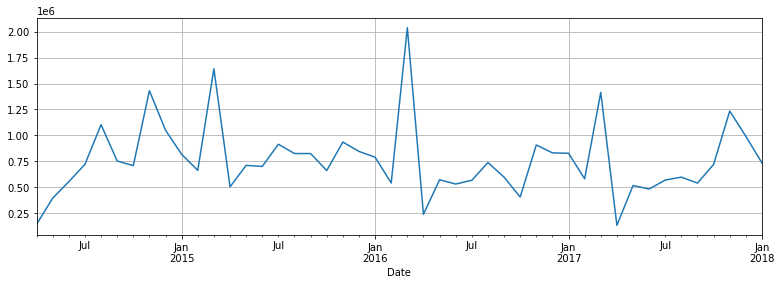

In [31]:
plt.figure(figsize=(13,4))
series = UP['VALUE']
series.plot(grid=True)

The following seasonal patterns can be observed:
1. Sale is the highest in March followed by November & August
2. Sale is the lowest in April

<AxesSubplot:ylabel='Density'>

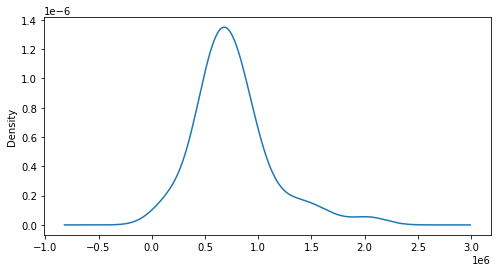

In [32]:
plt.figure(figsize=(8,4))
series.plot(kind='kde')
# series = np.log(df_new['VALUE']+1)
# series.hist()

Sales distribution is a little asymmetric and a little pointy to be Gaussian. Suggests the usage of data transformation to make it Gaussian. Let's try the boxcox transformation.

In [13]:
from scipy.stats import boxcox
UP['VALUE'], lam = boxcox(UP['VALUE'])
print('Lambda: %f' % lam)

Lambda: 0.433100


<AxesSubplot:ylabel='Density'>

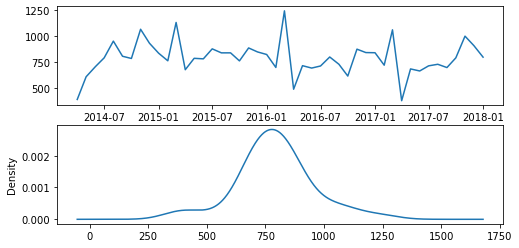

In [14]:
plt.figure(figsize=(8,4))
plt.figure(1)
# Line plot
plt.subplot(211)
plt.plot(UP['VALUE'])

# kde plot
plt.subplot(212)
UP['VALUE'].plot(kind='kde')
# UP['VALUE'].hist()


<AxesSubplot:>

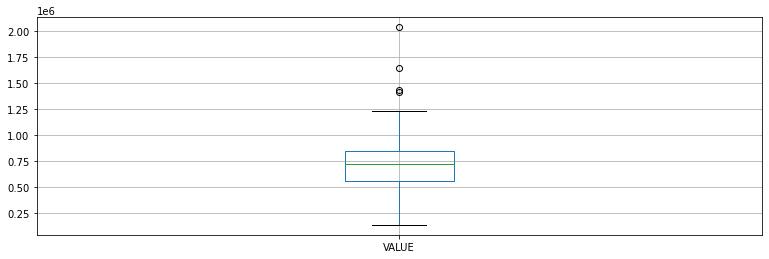

In [33]:
plt.figure(figsize=(13,4))
UP.boxplot()

<AxesSubplot:>

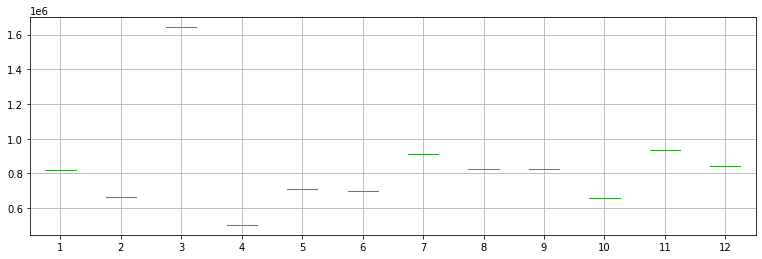

In [34]:
plt.figure(figsize=(13,4))
one_year = series['2015']
groups = one_year.groupby(pd.Grouper(freq='M'))

months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)

months.columns = range(1,13)
months.boxplot()


The above plot clearly shows the increase in sales in March followed by November

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

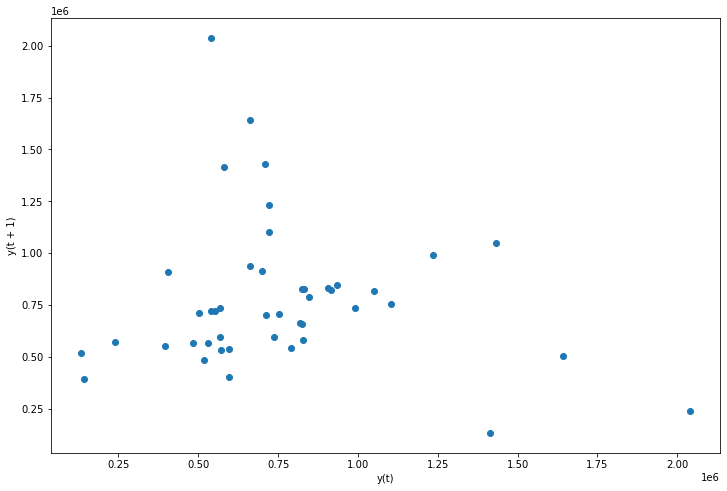

In [35]:
from pandas.plotting import lag_plot
lag_plot(series)

The above Lag plot shows a weak relationship of sale with its lag value. Let's try the autocorrelation plot to see if its correlated with any other day.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

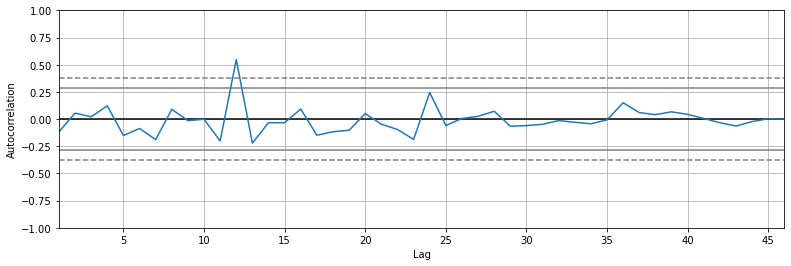

In [36]:
plt.figure(figsize=(13,4))
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

Autocorrelation plot above shows that sale data is correlated with past 12 month data.

#### Check for white noise

In [37]:
# Check 1: Does it have a zero mean?
UP['VALUE'].mean()

760970.7498913042

In [20]:
# Check 2: Variance changes over time?
print('2014 Variance: %f' % UP['2014'].var())
print('2015 Variance: %f' % UP['2015'].var())
print('2016 Variance: %f' % UP['2016'].var())
print('2017 Variance: %f' % UP['2017'].var())

2014 Variance: 40266.216990
2015 Variance: 12142.731798
2016 Variance: 33254.141611
2017 Variance: 31472.865185


Sales has non-zero mean & variance changes over time. Clearly the time series data is not white noise.

#### Check for Random Walk

In [21]:
# Check for Stationarity - Random Walks are non-stationary
print('2014 Mean: %f' % UP['2014'].mean())
print('2015 Mean: %f' % UP['2015'].mean())
print('2016 Mean: %f' % UP['2016'].mean())
print('2017 Mean: %f' % UP['2017'].mean())

2014 Mean: 783.572042
2015 Mean: 837.194848
2016 Mean: 771.302465
2017 Mean: 767.391744


In [22]:
print('2014-2015 Mean: %f' % df_ABC[df_ABC['FIN_YEAR']=='2014-2015']['VALUE'].mean())
print('2015-2016 Mean: %f' % df_ABC[df_ABC['FIN_YEAR']=='2015-2016']['VALUE'].mean())
print('2016-2017 Mean: %f' % df_ABC[df_ABC['FIN_YEAR']=='2016-2017']['VALUE'].mean())
print('2017-2018 Mean: %f' % df_ABC[df_ABC['FIN_YEAR']=='2017-2018']['VALUE'].mean())

2014-2015 Mean: 2212.382025
2015-2016 Mean: 2428.815755
2016-2017 Mean: 1147.648187
2017-2018 Mean: 1842.194600


In [23]:
# ADFuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(UP['VALUE'])
print('ADF Statistic %.3f' % result[0])
print('p-value %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' %(key, value))

ADF Statistic -7.524
p-value 0.000000
Critical values:
	1%: -3.585
	5%: -2.928
	10%: -2.602


Test Statistic < critical value (1%) and hence we will reject the null hypothesis and say that the time series is stationary

Time series is not a Random Walk for the following reasons:
1. It has no consistent mean & variance changes over time
2. Time series is stationary 

In [24]:
result = adfuller(df_ABC['VALUE'])
print('ADF Statistic %.3f' % result[0])
print('p-value %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' %(key, value))

ADF Statistic -15.420
p-value 0.000000
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### Decompose the time series data

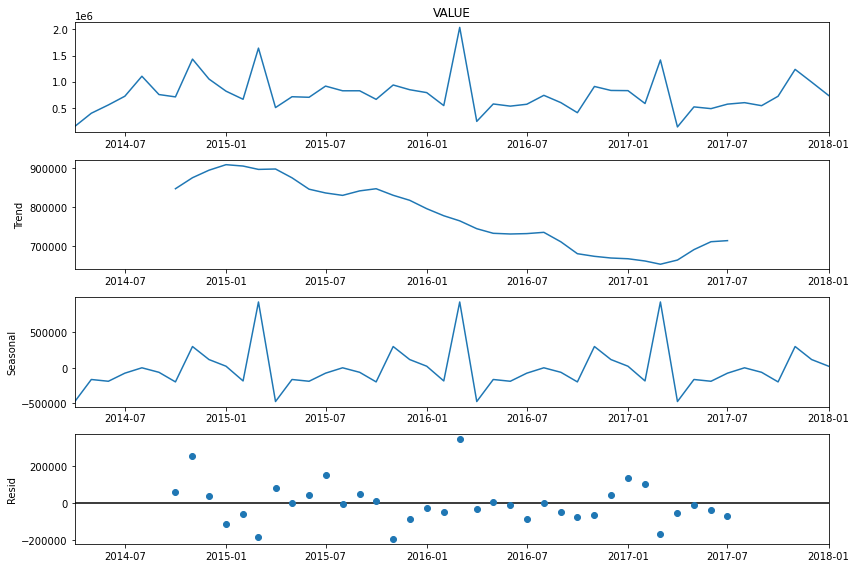

In [38]:
from pylab import rcParams

rcParams['figure.figsize'] =12,8
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(UP['VALUE'], model='additive')
fig = result.plot()

In [26]:
UP.shape

(46, 1)

### Build the persistence model

30
Test RMSE: 452480.091
Residual Mean: 8551.946


<AxesSubplot:ylabel='Density'>

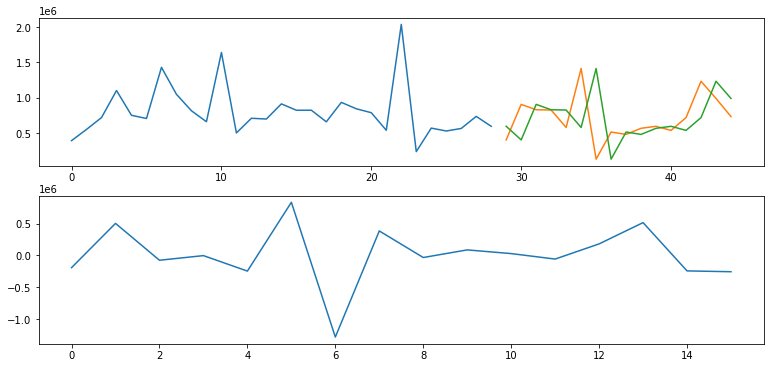

<Figure size 576x216 with 0 Axes>

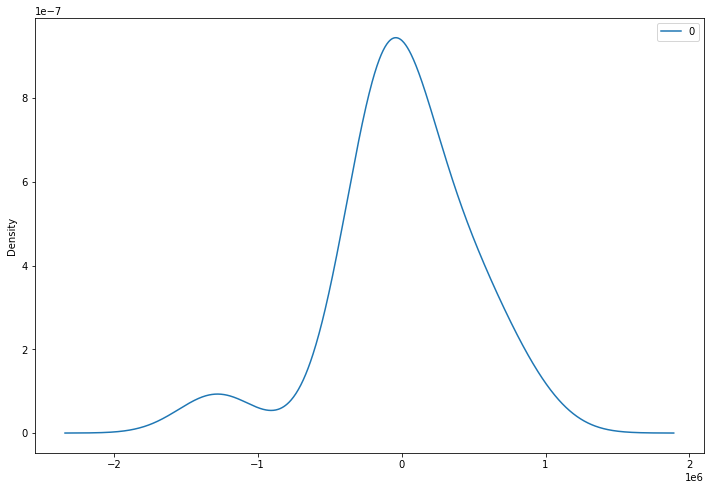

In [49]:
from sklearn.metrics import mean_squared_error

values = pd.DataFrame(UP.values)
df_UP = pd.concat([values.shift(1), values], axis=1)
df_UP.columns = ['t', 't+1']
X = df_UP.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# walk forward validation
predictions = [x for x in test_X]
residuals = [test_y[i] - predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

rmse = np.sqrt(mean_squared_error(test_y, predictions))
print('Test RMSE: %.3f' %rmse)
print('Residual Mean: %.3f' %residuals.mean())

plt.figure(figsize=(13,6))
plt.figure(1)

plt.subplot(211)
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])

plt.subplot(212)
plt.plot(residuals)

plt.figure(figsize=(8,3))
residuals.plot(kind='kde')

Take aways from the persistence model evaluation:
1. Persistence model RMSE = 452480.091
2. Residual mean = 8551.95 (there is a positive forecast bias and the model is under forecasting)
3. Residual plot shows that residuals are not random. There seems to be some pattern which the model has not captured.

#### Plot the ACF & PACF plots

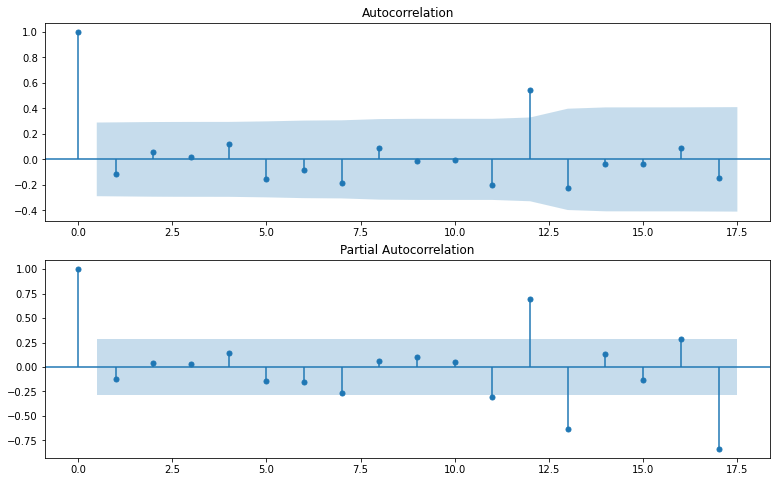

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(13,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(UP, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(UP, ax=ax2)


### Build the ARIMA model

In [76]:
X = UP['VALUE']
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
test

Date
2016-10-01     405397.035
2016-11-01     907754.040
2016-12-01     831337.992
2017-01-01     827758.980
2017-02-01     581322.015
2017-03-01    1414752.183
2017-04-01     132897.240
2017-05-01     516515.670
2017-06-01     483089.130
2017-07-01     569271.915
2017-08-01     597466.935
2017-09-01     539775.090
2017-10-01     720295.875
2017-11-01    1234663.965
2017-12-01     991006.515
2018-01-01     734645.700
Name: VALUE, dtype: float64

Predicted=621909.307136, Expected=405397.035000
Predicted=1028017.684258, Expected=907754.040000
Predicted=772320.035589, Expected=831337.992000
Predicted=578175.097134, Expected=827758.980000
Predicted=239157.120132, Expected=581322.015000
Predicted=921983.887368, Expected=1414752.183000
Predicted=918306.618742, Expected=132897.240000
Predicted=1011088.594925, Expected=516515.670000
Predicted=729714.662767, Expected=483089.130000
Predicted=593801.435404, Expected=569271.915000
Predicted=400661.507816, Expected=597466.935000
Predicted=642404.269873, Expected=539775.090000
Predicted=604100.258628, Expected=720295.875000
Predicted=798893.243790, Expected=1234663.965000
Predicted=669626.241853, Expected=991006.515000
Predicted=798739.634064, Expected=734645.700000
Test RMSE: 332600.140


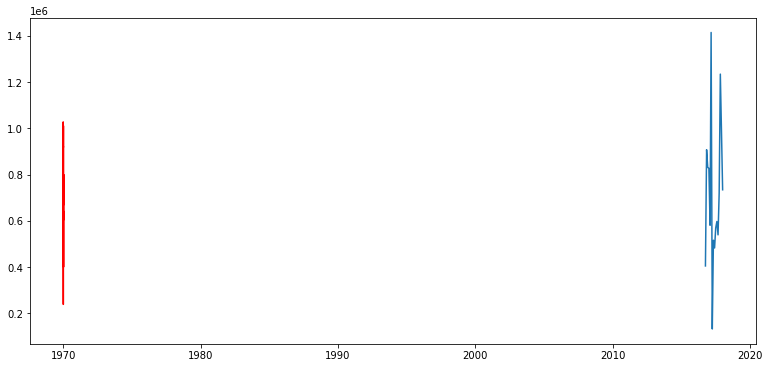

In [86]:
from statsmodels.tsa.arima_model import ARIMA

X = UP['VALUE']
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = list()

#walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(10,1,0))
    m_UP = model.fit(disp=0)
    
    output = m_UP.forecast()
    yhat = output[0]
    
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('Predicted=%f, Expected=%f' %(yhat,obs))

rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' %rmse)

plt.figure(figsize=(13,6))
plt.plot(test)
plt.plot(predictions, color='red')


In [44]:
m_UP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.VALUE   No. Observations:                   45
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -641.312
Method:                       css-mle   S.D. of innovations         358850.515
Date:                Thu, 23 Sep 2021   AIC                           1288.623
Time:                        11:55:12   BIC                           1294.043
Sample:                    05-01-2014   HQIC                          1290.644
                         - 01-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1542.9063   3983.579     -0.387      0.699   -9350.577    6264.764
ma.L1.D.VALUE    -0.9984      0.070    -14.290      0.000      -1.135      -0.862
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0016           +0.0000j            1.0016            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
y_hat= y.copy()
y_hat['arima forecast'] = m1.predict(36)

plt.figure(figsize=(12,4))
plt.plot(y, label='Observed')
plt.plot(y_hat['arima forecast'], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('ARIMA Method')
plt.show()

<AxesSubplot:xlabel='Date'>

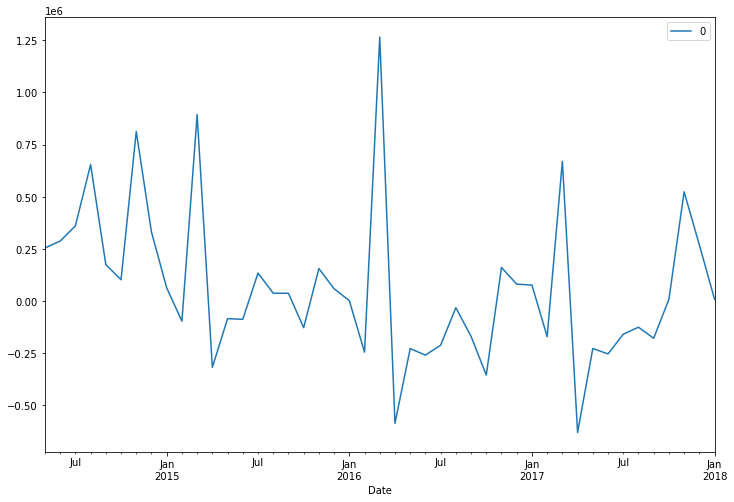

In [45]:
residual_UP = pd.DataFrame(m_UP.resid)
residual_UP.plot()

<AxesSubplot:ylabel='Density'>

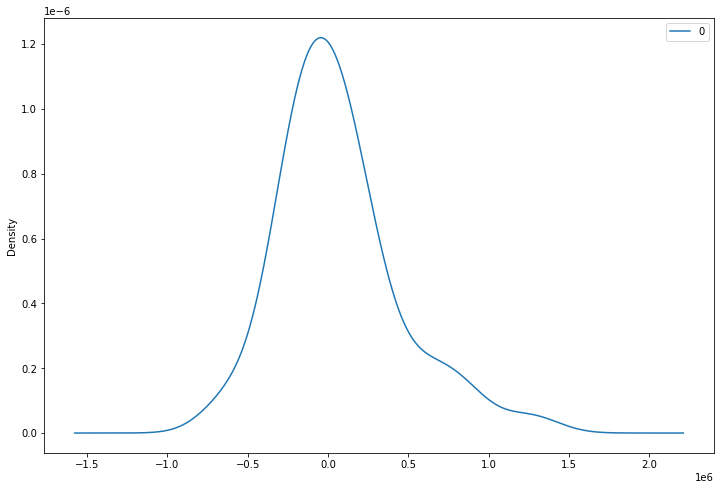

In [46]:
residual_UP.plot(kind='kde')

In [48]:
residual_UP.describe()

,0
count,4.500000e+01
mean,6.378827e+04
std,3.721472e+05
min,-6.298189e+05
25%,-1.707587e+05
50%,8.582838e+03
75%,1.743551e+05
max,1.264858e+06
